In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM

In [ ]:
data=pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')

# Preprocessing and EDA

In [ ]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [ ]:
data.shape

(2035, 8)

In [ ]:
data.isna().sum()


Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [ ]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [ ]:
data.dtypes

Date                     object
Open                    float64
High                    float64
Low                     float64
Last                    float64
Close                   float64
Total Trade Quantity      int64
Turnover (Lacs)         float64
dtype: object

In [ ]:
data['Date'].value_counts()

2018-09-28    1
2013-04-10    1
2013-03-20    1
2013-03-21    1
2013-03-22    1
             ..
2016-01-11    1
2016-01-12    1
2016-01-13    1
2016-01-14    1
2010-07-21    1
Name: Date, Length: 2035, dtype: int64

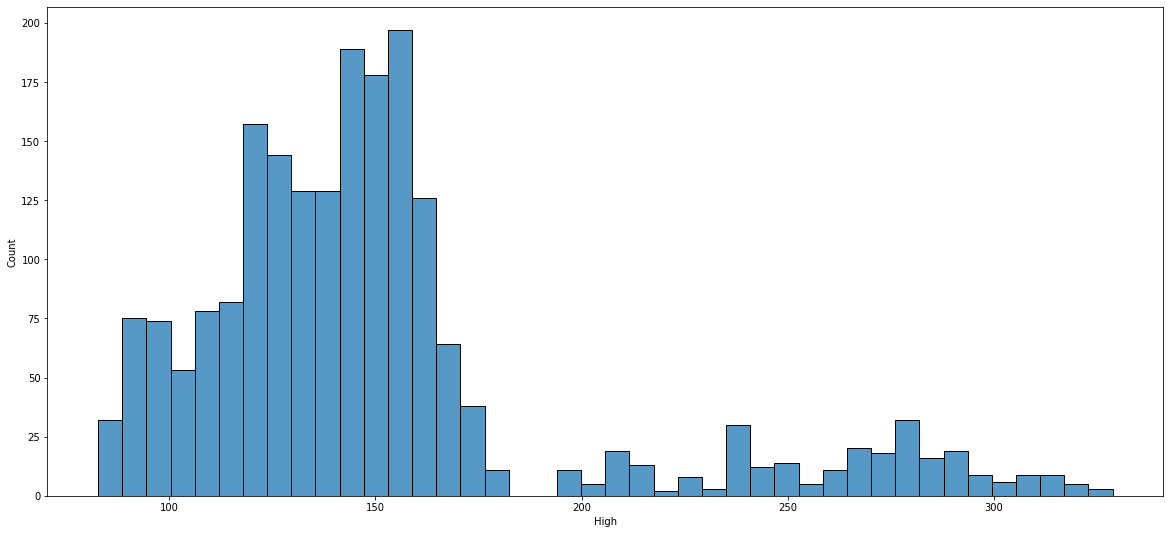

In [ ]:
plt.figure(figsize=(20,9))
sns.histplot(data['High'])

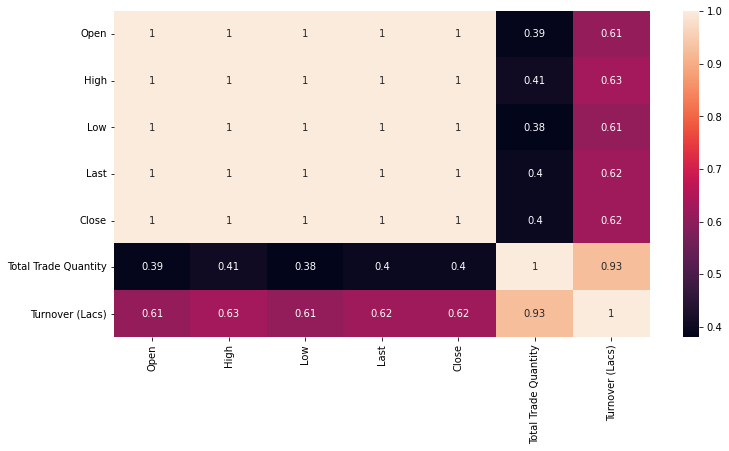

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(data.corr(),annot=True)

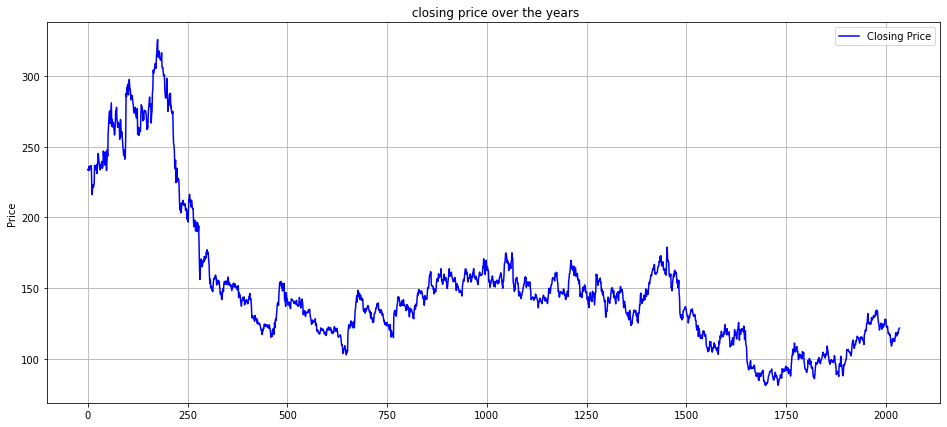

In [ ]:
plt.figure(figsize=(10,6))
data['Close'].plot(kind='line',figsize=(16,7),color='b',label="Closing Price")

plt.ylabel("Price")
plt.legend(loc="upper right")
plt.title(" closing price over the years")
plt.grid()

In [ ]:
data = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Close'])
for i in range(0,len(data)):
    new_data['Close'][i] = data['Close'][i]

In [ ]:
# MinMax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(new_data).reshape(-1,1))

In [ ]:
# train and test sets
set_size = int(len(data)*0.5)
train = scaled_data[0:set_size,:]
test = scaled_data[set_size:,:]

In [ ]:

def create_dataset(dataset, time_step):
    x, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        x.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(x), np.array(y)

In [ ]:
time_step = 100
X_train, Y_train = create_dataset(train, time_step)
X_test, Y_test = create_dataset(test, time_step)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_train=np.asarray(X_train).astype(np.float)
Y_train=np.asarray(Y_train).astype(np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


# LSTM mdoel

In [ ]:
# creating the model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train, Y_train, epochs=1, batch_size=1, verbose=2)

916/916 - 161s - loss: 0.0046


In [ ]:
#Now making prediction
X_test=np.asarray(X_test).astype(np.float)
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
import math
from sklearn.metrics import mean_squared_error
print("MSE for Training Data",math.sqrt(mean_squared_error(Y_train,train_predict)))
print("MSE for Testing Data",math.sqrt(mean_squared_error(Y_test,test_predict)))

MSE for Training Data 175.22801735732162
MSE for Testing Data 129.50189666723463


Text(0, 0.5, 'Closing price')

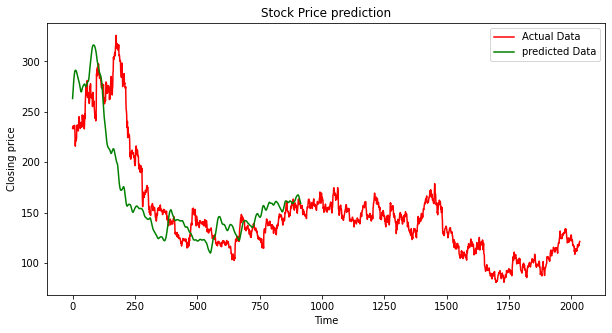

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(new_data['Close'],color='red',label='Actual Data')
plt.plot(train_predict,color='Green',label = 'predicted Data')
plt.legend()
plt.title("Stock Price prediction")
plt.xlabel('Time')
plt.ylabel('Closing price')

In [ ]:
#thank you